In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.family'] = 'NanumGothic'

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

import torch
import torch.nn as nn
from torch.autograd import Variable

import lightgbm as lgb

import os, sys, random
from pathlib import Path
import glob

from tqdm import tqdm
from fastprogress import progress_bar

import pickle

import warnings
warnings.filterwarnings(action='ignore')

In [2]:
CUR_DIR = Path.cwd()
DATA_DIR = CUR_DIR / 'data/preprocessed'
DATA_DIR

WindowsPath('C:/Users/안현준/풍년보험/data/preprocessed')

In [3]:
df = pd.read_csv(f'{str(DATA_DIR)}/summary.csv', encoding='utf-8')
df

,연월,감자,고구마,고추(화건),깻잎,녹두(국산),단감,당근(무세척),대파,들깨(국산),...,양배추,양파,오이(가시),적상추,참외,콩(흰콩국산),토마토,팥(국산),포도(캠벨),풋고추
0,2001_1,12191.0,8348.0,224565.0,16365.0,237774.0,14214.000000,9313.0,855.0,171565.0,...,3186.0,13734.0,20007.0,8772.0,18722.666667,101957.0,8916.333333,147000.0,4490.857143,33783.0
1,2001_2,11558.0,9567.0,231208.0,12367.0,241875.0,16394.000000,10258.0,645.0,173458.0,...,2747.0,14062.0,23917.0,8510.0,35444.333333,95875.0,15831.666667,147875.0,6980.714286,58408.0
2,2001_3,11885.0,13990.0,231962.0,10785.0,242000.0,21579.000000,11277.0,669.0,183885.0,...,2783.0,14422.0,19942.0,6909.0,52166.000000,93885.0,22747.000000,147154.0,9470.571429,60646.0
3,2001_4,12133.0,14367.0,230333.0,8813.0,239833.0,21671.000000,13658.0,528.0,198375.0,...,2574.0,8752.0,13074.0,5284.0,39989.000000,91575.0,19756.000000,147000.0,11960.428571,24283.0
4,2001_5,22625.0,13594.0,238083.0,7533.0,238000.0,23043.400000,14900.0,803.0,199125.0,...,2913.0,5150.0,9236.0,4828.0,21800.000000,89142.0,13583.000000,147000.0,14450.285714,22025.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,2020_8,32806.0,55765.0,692489.0,37550.0,463910.0,37260.285714,45977.0,3081.0,488530.0,...,9079.0,20492.0,32260.0,49308.0,49751.000000,184790.0,29638.000000,355400.0,23571.000000,51334.0
236,2020_9,35413.0,38834.0,871229.0,35653.0,498295.0,36936.142857,70528.0,3178.0,527714.0,...,13033.0,23636.0,35076.0,30401.0,70438.000000,188171.0,50354.000000,365095.0,21720.000000,92749.0
237,2020_10,34283.0,33565.0,812179.0,22075.0,542379.0,36612.000000,66874.0,3019.0,571126.0,...,17068.0,23749.0,15384.0,11982.0,64834.500000,189516.0,50018.000000,382979.0,20284.000000,63283.0
238,2020_11,35830.0,36263.0,824724.0,18950.0,586057.0,32381.000000,42214.0,2982.0,606486.0,...,12744.0,25540.0,20919.0,11180.0,59231.000000,203514.0,35261.000000,453448.0,21071.333333,49019.0


In [4]:
crops = df.columns[1:]

In [5]:
crop2id = {crop: i for i, crop in enumerate(crops)}
id2crop = {i: crop for i, crop in enumerate(crops)}

In [6]:
with open('./results/crop_cluster.pickle', 'rb') as f:
    cluster_id = pickle.load(f)

In [7]:
last_year_month = df.iloc[-1]['연월']
last_year = int(str(last_year_month[:4]))
last_month = int(str(last_year_month[5:]))
print(last_year, last_month)

2020 12


In [8]:
for i in range(12):
    if last_month == 12:
        last_year += 1
        last_month = 1
    else:
        last_month += 1
    
    row = [f'{last_year}_{last_month}']
    for j in range(len(df.columns) - 1):
        row.append(np.nan)
    series = pd.Series(row, index=df.columns)
    df = df.append(series, ignore_index=True)

df['year'] = df['연월'].apply(lambda x: int(str(x[:4])))
df['month'] = df['연월'].apply(lambda x: int(str(x[5:])))

In [9]:
date2d = {date: i for i, date in enumerate(df['연월'])}
d2date = {i: date for i, date in enumerate(df['연월'])}

In [10]:
df_crops = []
for crop in crops:
    df_crop = pd.DataFrame({
        'crop_id': crop2id[crop],
        'd': range(1, df.shape[0] + 1),
        'price': df[crop]
    })
    df_crops.append(df_crop)
df_crops = pd.concat(df_crops, axis=0).reset_index(drop=True)
df_crops

,crop_id,d,price
0,0,1,12191.0
1,0,2,11558.0
2,0,3,11885.0
3,0,4,12133.0
4,0,5,22625.0
...,...,...,...
8059,31,248,NaN
8060,31,249,NaN
8061,31,250,NaN
8062,31,251,NaN


# Feature Engineering
- Lag
- Moving Average/Stddev
- momentum
- month
- season
- cluster_id
- crop_id

In [11]:
SHIFT_DAY = 12 # predict 1 years, 12 months
print('Create lags')

LAG_DAYS = [col for col in range(SHIFT_DAY, SHIFT_DAY + 36)]

df_crops = df_crops.assign(**{
        '{}_lag_{}'.format(col, lag): df_crops.groupby(['crop_id'])[col].transform(lambda x: x.shift(lag))
        for lag in LAG_DAYS
        for col in ['price']
    })


TARGET = 'price'
for i in [3, 6, 9, 12, 18, 24, 30, 36]:
    df_crops[f'moving_avg_{i}'] = df_crops.groupby(['crop_id'])[TARGET].transform(lambda x: x.shift(SHIFT_DAY).rolling(i).mean()).astype(np.float16)
    df_crops[f'moving_std_{i}'] = df_crops.groupby(['crop_id'])[TARGET].transform(lambda x: x.shift(SHIFT_DAY).rolling(i).std()).astype(np.float16)
    

Create lags


In [12]:
def set_momentum(x):
    x1 = x.shift(SHIFT_DAY + 1).rolling(3).mean()
    x2 = x.shift(SHIFT_DAY).rolling(3).mean()

    return x2 / x1

def set_momentum_type(x):
    if x < 0.8:
        return -1
    elif x > 1.2:
        return 1
    return 0

df_crops['price_momentum'] = df_crops.groupby(['crop_id'])['price'].apply(lambda x: set_momentum(x))
df_crops['price_momentum'] = df_crops['price_momentum'].apply(lambda x: set_momentum_type(x))



def set_season(x):
    if x in [3, 4, 5]:
        return 'spring'
    elif x in [6, 7, 8]:
        return 'summer'
    elif x in [9, 10, 11]:
        return 'fall'
    return 'winter'

df_crops['연월'] = df_crops['d'].apply(lambda x: d2date[x - 1])
df_crops['year'] = df_crops['연월'].apply(lambda x: int(str(x[:4])))
df_crops['month'] = df_crops['연월'].apply(lambda x: int(str(x[5:])))
df_crops['season'] = df_crops['month'].apply(lambda x: set_season(x))

In [13]:
encoder = LabelEncoder()
df_crops['season'] = encoder.fit_transform(df_crops['season'])
df_crops['cluster_id'] = df_crops['crop_id'].apply(lambda x: cluster_id[id2crop[x]]['price_class'])
df_crops

,crop_id,d,price,price_lag_12,price_lag_13,price_lag_14,price_lag_15,price_lag_16,price_lag_17,price_lag_18,...,moving_avg_30,moving_std_30,moving_avg_36,moving_std_36,price_momentum,연월,year,month,season,cluster_id
0,0,1,12191.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0,2001_1,2001,1,3,0
1,0,2,11558.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0,2001_2,2001,2,3,0
2,0,3,11885.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0,2001_3,2001,3,1,0
3,0,4,12133.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0,2001_4,2001,4,1,0
4,0,5,22625.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0,2001_5,2001,5,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8059,31,248,NaN,51334.0,45886.0,42578.0,40602.0,47785.0,62178.0,84035.0,...,49408.0,12216.0,49536.0,13528.0,0,2021_8,2021,8,2,1
8060,31,249,NaN,92749.0,51334.0,45886.0,42578.0,40602.0,47785.0,62178.0,...,50560.0,14480.0,50400.0,15224.0,1,2021_9,2021,9,0,1
8061,31,250,NaN,63283.0,92749.0,51334.0,45886.0,42578.0,40602.0,47785.0,...,51296.0,14536.0,51232.0,15088.0,0,2021_10,2021,10,0,1
8062,31,251,NaN,49019.0,63283.0,92749.0,51334.0,45886.0,42578.0,40602.0,...,51552.0,14424.0,51552.0,14920.0,0,2021_11,2021,11,0,1


In [14]:
df_crops.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8064 entries, 0 to 8063
Data columns (total 61 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   crop_id         8064 non-null   int64  
 1   d               8064 non-null   int64  
 2   price           7680 non-null   float64
 3   price_lag_12    7680 non-null   float64
 4   price_lag_13    7648 non-null   float64
 5   price_lag_14    7616 non-null   float64
 6   price_lag_15    7584 non-null   float64
 7   price_lag_16    7552 non-null   float64
 8   price_lag_17    7520 non-null   float64
 9   price_lag_18    7488 non-null   float64
 10  price_lag_19    7456 non-null   float64
 11  price_lag_20    7424 non-null   float64
 12  price_lag_21    7392 non-null   float64
 13  price_lag_22    7360 non-null   float64
 14  price_lag_23    7328 non-null   float64
 15  price_lag_24    7296 non-null   float64
 16  price_lag_25    7264 non-null   float64
 17  price_lag_26    7232 non-null   f

# split train-valid-test set

In [36]:
size = df_crops[~df_crops.price.isnull()].shape[0] // df_crops.crop_id.nunique()
index_list = list(range(size)) # NaN인 부분은 Infer하는 부분이므로 NaN이 아닌부분이 실제 학습데이터

# TRAIN : VALID = 8 : 2
train_idx, valid_idx = train_test_split(index_list, test_size=0.2, shuffle=False, random_state=42)

In [38]:
features = dict.fromkeys(df_crops.columns, 0)
not_features = ['d', 'price', 'price_momentum', '연월', 'year']

for f in not_features:
    del features[f]

FEATURES = list(features.keys())
TARGET = 'price'

In [53]:
X_train, y_train, X_valid, y_valid = [], [], [], []


for crop_id in df_crops.crop_id.unique():
    cur = df_crops[df_crops.crop_id == crop_id].reset_index(drop=True)
    X_train.append(cur.loc[train_idx, FEATURES])
    y_train.append(cur.loc[train_idx, TARGET])
    X_valid.append(cur.loc[valid_idx, FEATURES])
    y_valid.append(cur.loc[valid_idx, TARGET])
    
X_train = pd.concat(X_train, axis=0).reset_index(drop=True)
y_train = pd.concat(y_train, axis=0).reset_index(drop=True)
X_valid = pd.concat(X_valid, axis=0).reset_index(drop=True)
y_valid = pd.concat(y_valid, axis=0).reset_index(drop=True)

X_train.shape[0], y_train.shape[0], X_valid.shape[0], y_valid.shape[0]

(6144, 6144, 1536, 1536)

In [54]:
def fix_seed(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

# Train Model

In [68]:
SEED = 42
fix_seed(seed=SEED)

params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'mape',
    'subsample_freq': 1,
    'learning_rate': 0.05,
    'num_leaves': 128,
    'min_data_in_leaf': 128,
    'feature_fraction': 0.75,
    'bagging_fraction': 0.75,
    'max_bin': 128,
    'n_estimators': 10000,
    'boost_from_average': False,
    'verbose': -1,
    'early_stopping_rounds': None,
    'seed': SEED,
}

evals_results = {}

train_data = lgb.Dataset(X_train, label=y_train)
valid_data = lgb.Dataset(X_valid, label=y_valid)

model = lgb.train(params,
                  train_set=train_data,
                  valid_sets = [train_data, valid_data],
                  valid_names = ['train', 'valid'],
                  evals_result=evals_results,
                  verbose_eval=500,
                 )

[500]	train's mape: 0.100254	valid's mape: 0.102399
[1000]	train's mape: 0.0763832	valid's mape: 0.105382
[1500]	train's mape: 0.0637706	valid's mape: 0.107462
[2000]	train's mape: 0.0556545	valid's mape: 0.108977
[2500]	train's mape: 0.0497322	valid's mape: 0.110693
[3000]	train's mape: 0.0451487	valid's mape: 0.111808
[3500]	train's mape: 0.0417384	valid's mape: 0.112642
[4000]	train's mape: 0.0393571	valid's mape: 0.113074
[4500]	train's mape: 0.0376095	valid's mape: 0.113644
[5000]	train's mape: 0.035586	valid's mape: 0.114301
[5500]	train's mape: 0.0341144	valid's mape: 0.114723
[6000]	train's mape: 0.0327419	valid's mape: 0.114963
[6500]	train's mape: 0.0319092	valid's mape: 0.115338
[7000]	train's mape: 0.0311606	valid's mape: 0.115672
[7500]	train's mape: 0.0299607	valid's mape: 0.115974
[8000]	train's mape: 0.0293013	valid's mape: 0.116352
[8500]	train's mape: 0.0287044	valid's mape: 0.116467
[9000]	train's mape: 0.02823	valid's mape: 0.116639
[9500]	train's mape: 0.0272322	va

# Predict

In [69]:
%%time
pred = model.predict(df_crops.loc[:, FEATURES])
df_crops['pred_price'] = pred

Wall time: 18.4 s


In [70]:
df_crops

,crop_id,d,price,price_lag_12,price_lag_13,price_lag_14,price_lag_15,price_lag_16,price_lag_17,price_lag_18,...,moving_std_30,moving_avg_36,moving_std_36,price_momentum,연월,year,month,season,cluster_id,pred_price
0,0,1,12191.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0,2001_1,2001,1,3,0,12671.840043
1,0,2,11558.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0,2001_2,2001,2,3,0,14223.632715
2,0,3,11885.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0,2001_3,2001,3,1,0,14658.669814
3,0,4,12133.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0,2001_4,2001,4,1,0,16048.912606
4,0,5,22625.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0,2001_5,2001,5,1,0,16032.049901
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8059,31,248,NaN,51334.0,45886.0,42578.0,40602.0,47785.0,62178.0,84035.0,...,12216.0,49536.0,13528.0,0,2021_8,2021,8,2,1,51229.414671
8060,31,249,NaN,92749.0,51334.0,45886.0,42578.0,40602.0,47785.0,62178.0,...,14480.0,50400.0,15224.0,1,2021_9,2021,9,0,1,70389.648956
8061,31,250,NaN,63283.0,92749.0,51334.0,45886.0,42578.0,40602.0,47785.0,...,14536.0,51232.0,15088.0,0,2021_10,2021,10,0,1,40482.972822
8062,31,251,NaN,49019.0,63283.0,92749.0,51334.0,45886.0,42578.0,40602.0,...,14424.0,51552.0,14920.0,0,2021_11,2021,11,0,1,51179.942012


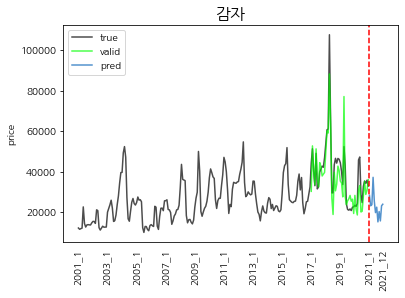

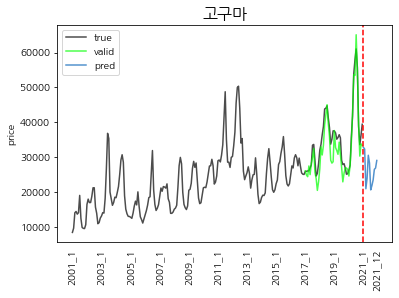

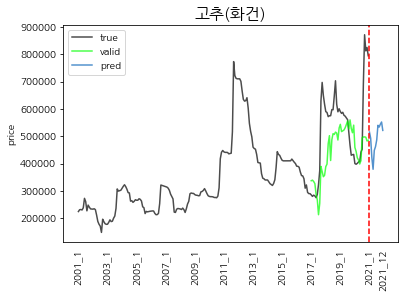

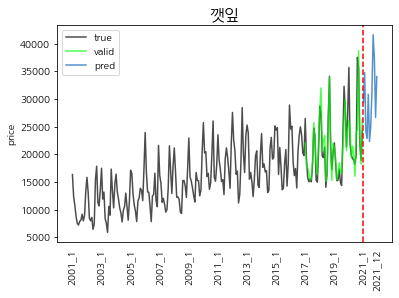

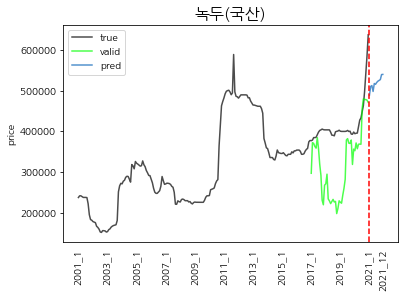

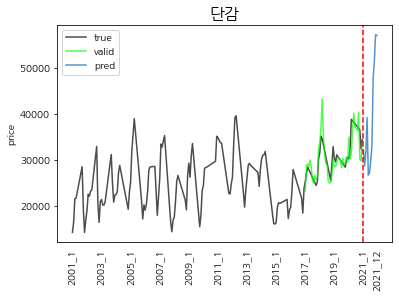

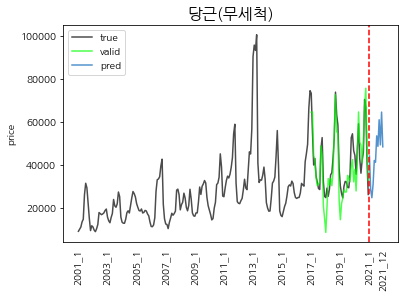

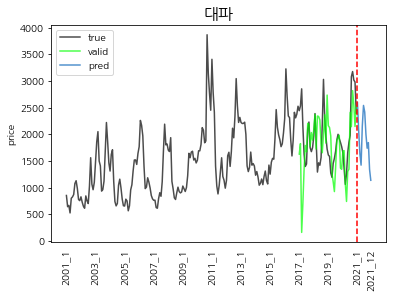

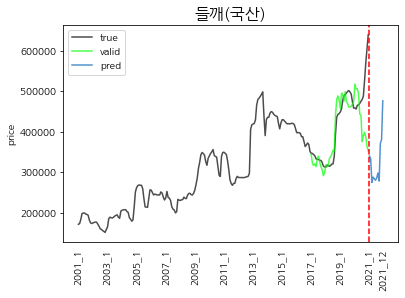

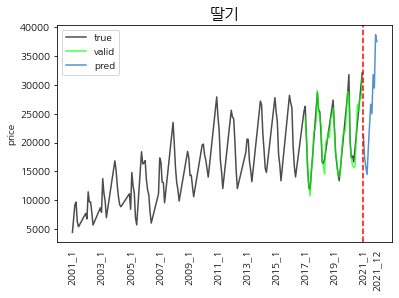

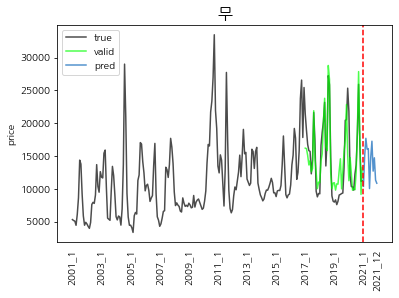

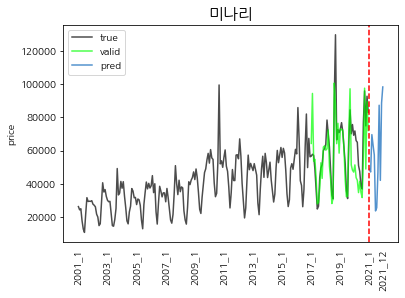

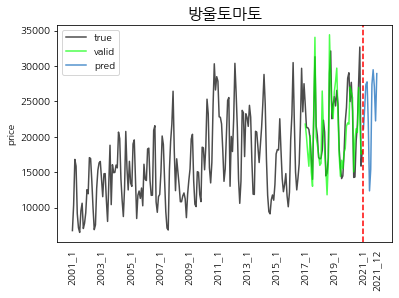

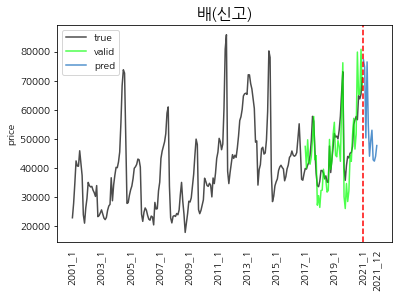

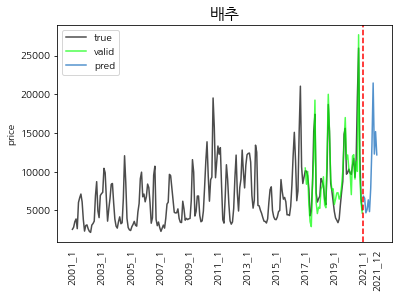

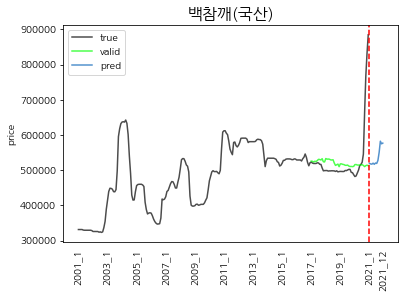

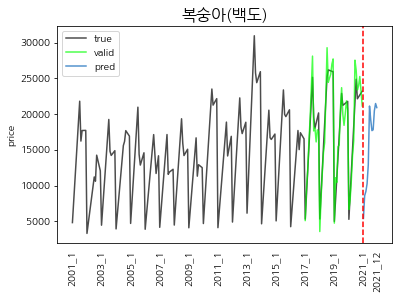

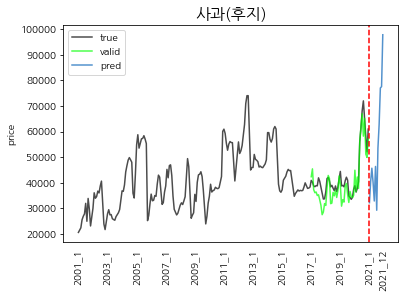

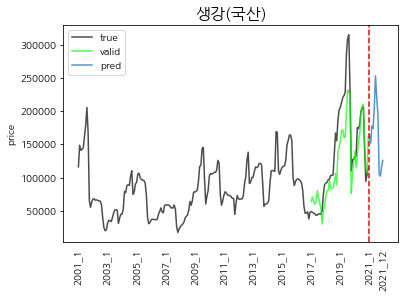

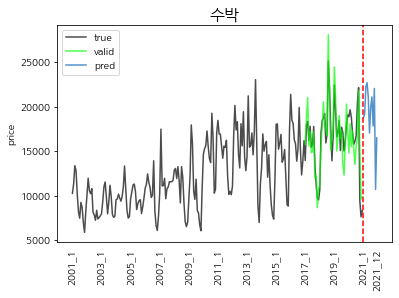

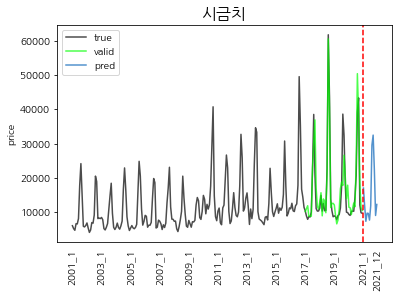

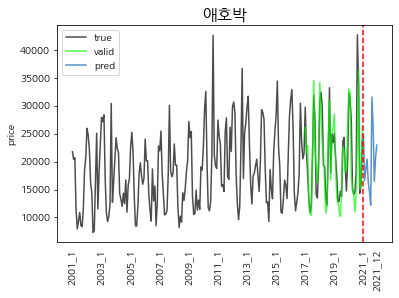

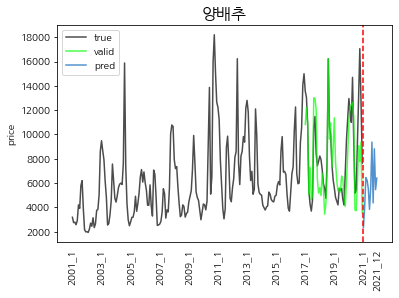

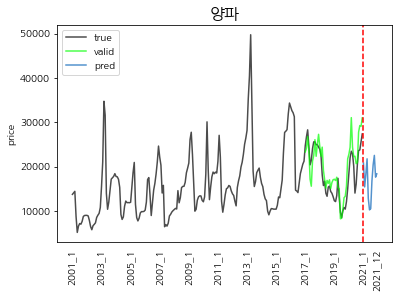

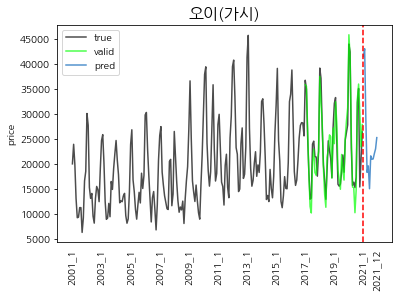

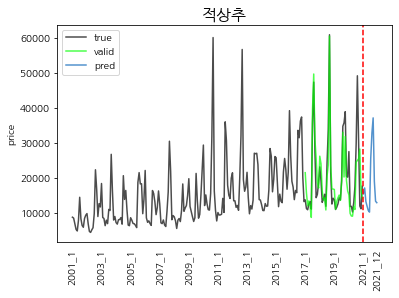

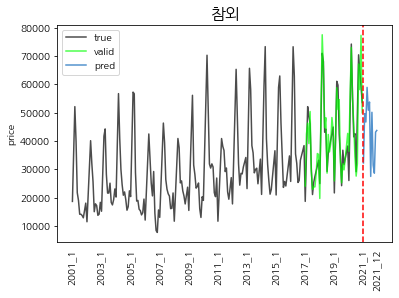

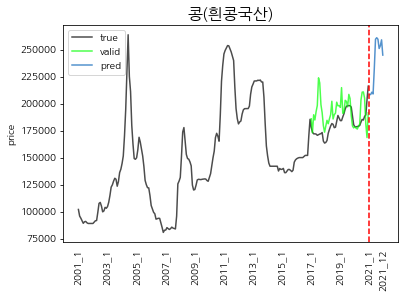

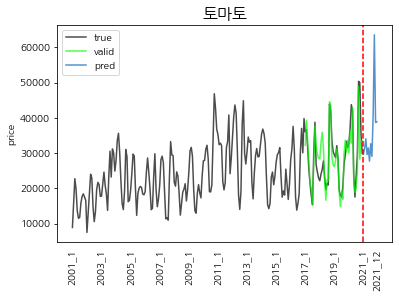

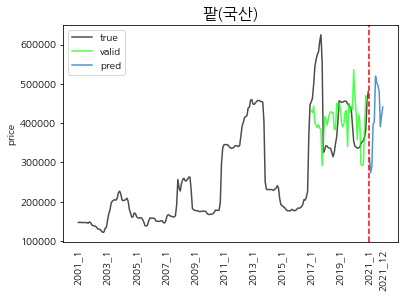

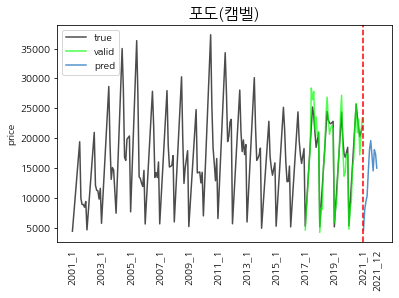

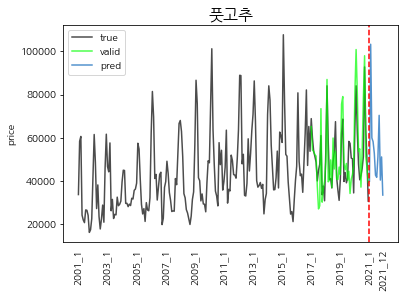

In [71]:
for crop_id in df_crops.crop_id.unique():
    cur = df_crops[df_crops.crop_id == crop_id].reset_index(drop=True)
    
    #sns.lineplot(range(size), cur.loc[:size-1, 'price'], color='black', alpha=0.7, label='true')
    #sns.lineplot(range(size), cur.loc[:size-1, 'pred_price'], color='lime', alpha=0.7, label='train')
    #sns.lineplot(range(size, cur.shape[0]), cur.loc[size:, 'pred_price'], color='#5392cd', label='pred')
    
    train_valid = np.append(train_idx, valid_idx)
    sns.lineplot(train_valid, cur.loc[train_valid, 'price'], color='black', alpha=0.7, label='true')
    sns.lineplot(valid_idx, cur.loc[valid_idx, 'pred_price'], color='lime', alpha=0.7, label='valid')
    sns.lineplot(range(size, cur.shape[0]), cur.loc[size:, 'pred_price'], color='#5392cd', label='pred')
    plt.axvline(x=size, color='red', linestyle='--')
    
    crop_name = id2crop[crop_id]
    plt.title(crop_name, fontsize=16)
    
    year_ticks = []
    for i, year_month in enumerate(cur['연월']):
        if i == 0 or i == len(cur['연월']) - 1:
            year_ticks.append(year_month)
        elif cur.at[i, 'year'] % 2 and cur.at[i, 'month'] == 1: 
            year_ticks.append(year_month)
        else: 
            year_ticks.append('')
            
    plt.tick_params(bottom=False)
    plt.xticks(
        np.arange(0, len(year_ticks)),
        year_ticks,
        rotation=90
    )
    
    plt.show()

In [72]:
df_crops.to_csv('./results_LGBM/predict_prices_mape.csv', encoding='utf-8-sig', drop)